## Training of SVHN using 152-layer ResNet with constant depth

In [ ]:
import tensorflow as tf
import numpy as np
from utils.neuralnets.ResNet152 import ResNet152
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Input,Flatten,Dense
from tensorflow.keras import Model
import tensorflow_datasets as tfds
import random

In [3]:
data=tfds.load('svhn_cropped')
data

{'train': <PrefetchDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'test': <PrefetchDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'extra': <PrefetchDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>}

In [4]:
def train_val_split(data1,data2,number_of_samples=[400,100]):
    val = []
    val_label = []
    train = []
    train_label =[]
    label_count = np.zeros(10)
    EXTRA_COUNT = 30000
    for sample in data1:
        if label_count[sample['label']] < number_of_samples[0]:
            val.append(sample['image'].numpy().astype('float32'))
            val_label.append(sample['label'].numpy().astype('float32'))
            label_count[sample['label']] += 1
        else:
            train.append(sample['image'].numpy().astype('float32'))
            train_label.append(sample['label'].numpy().astype('float32'))
    label_count = np.zeros(10)
    extra_count = 0
    for sample in data2:
        if label_count[sample['label']] < number_of_samples[1]:
            val.append(sample['image'].numpy().astype('float32'))
            val_label.append(sample['label'].numpy().astype('float32'))
            label_count[sample['label']] += 1
        else:
            train.append(sample['image'].numpy().astype('float32'))
            train_label.append(sample['label'].numpy().astype('float32'))
        extra_count += 1
        if extra_count > EXTRA_COUNT:
            break
    return (np.array(train),np.array(train_label)),(np.array(val),np.array(val_label))

In [5]:
train_data, val_data = train_val_split(data['train'],data['extra'])
x_train ,y_train = train_data
x_val, y_val = val_data

In [6]:
x_test = np.array([sample['image'].numpy().astype('float32') for sample in data['test']])
y_test = np.array([sample['label'].numpy().astype('float32') for sample in data['test']])

In [7]:
input_shape = x_train.shape[1:]
num_class = 10
model = ResNet152(input_shape=input_shape,num_class=num_class)

In [8]:
batch_size = 128
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
validation_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1,nesterov=True)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


epochs = 25
history = [[],[],[]]
for epoch in range(epochs):
    print("Epoch %d/%d" % (epoch+1,epochs))
    if (epoch==15) | (epoch==20):
        optimizer.learning_rate = optimizer.learning_rate/10
    
    start_time = time.time()
    step = 0
    for x_batch_train, y_batch_train in train_data:
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y_batch_train, logits)
        if step % 200 == 0:
            print(
                "Training loss at step %d: %.4f"
                % (step, float(loss_value))
            )
        step += 1
        if step > len(x_train)/batch_size:
            break

    history[0].append(loss_value.numpy())
    train_acc = train_acc_metric.result()
    train_acc_metric.reset_states()
    
    step = 0
    for x_batch_val, y_batch_val in validation_data:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)
        step += 1
        if step > len(x_val)/batch_size:
            break
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    history[1].append(train_acc.numpy())
    history[2].append(val_acc.numpy())
    print("Training accuracy: %.4f" % (float(train_acc),)
          ,"Validation accuracy: %.4f" % (float(val_acc),),"Time taken: %.2fs" % (time.time() - start_time))


Epoch 1/25
Training loss at step 0: 20.4907
Training loss at step 200: 2.3650
Training loss at step 400: 2.3381
Training loss at step 600: 2.3401
Training accuracy: 0.1818 Validation accuracy: 0.1004 Time taken: 342.69s
Epoch 2/25
Training loss at step 0: 1.8792
Training loss at step 200: 2.2816
Training loss at step 400: 2.0295
Training loss at step 600: 0.9624
Training accuracy: 0.4057 Validation accuracy: 0.5968 Time taken: 327.17s
Epoch 3/25
Training loss at step 0: 3.9366
Training loss at step 200: 0.6660
Training loss at step 400: 0.5560
Training loss at step 600: 0.2592
Training accuracy: 0.8553 Validation accuracy: 0.8488 Time taken: 326.84s
Epoch 4/25
Training loss at step 0: 4.2145
Training loss at step 200: 0.3197
Training loss at step 400: 0.4229
Training loss at step 600: 0.1225
Training accuracy: 0.9149 Validation accuracy: 0.8988 Time taken: 326.88s
Epoch 5/25
Training loss at step 0: 3.3797
Training loss at step 200: 0.2708
Training loss at step 400: 0.3420
Training los

In [1]:
y_pred = model.predict(x_test)
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(y_test, y_pred)
m.result().numpy()

0.93913682

In [3]:
# log = np.array(history)
# np.save("./Logs/ResNet152_svhn",log)

In [4]:
with open('./Logs/ResNet152_svhn.npy', 'rb') as f:
     log = np.load(f)

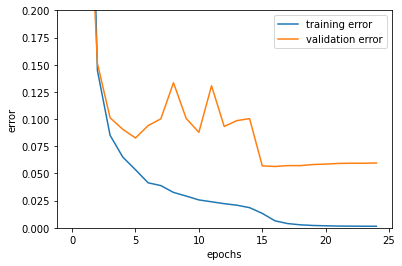

In [6]:
import matplotlib.pyplot as plt
plt.plot(1-log[1],label='training error')
plt.plot(1-log[2],label='validation error')
plt.ylim(0,0.2)
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()

In [ ]:
# model.save("./Models/ResNet152_svhn")